# Iterative Random Shuffling Volume Denoising (IRSVD)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install cupy-cuda12x
    !pip install opticalflow3D
    !apt-file update
    !apt install libcudart11.0
    !apt install libcublas11
    !apt install libcufft10
    !apt install libcusparse11
    !apt install libnvrtc11.2
    from google.colab import drive
    drive.mount('/content/drive')
    !cp drive/Shareddrives/TomogramDenoising/tomograms/small_vol.tif .
else:
    !cp /home/vruiz/repos/microscopy-processing/FlowDenoising/src/small_vol.tif .

In [2]:
import opticalflow3D
import warnings
from numba.core.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Farneback two frame motion estimation

In [144]:
farneback = opticalflow3D.Farneback3D(iters=5,
                                      num_levels=3,
                                      scale=0.5,
                                      spatial_size=13,
                                      presmoothing=None,
                                      filter_type="gaussian",
                                      filter_size=11,
                                     )

In [145]:
import numpy as np

In [146]:
def project_A_to_B(A, B):
  output_vz, output_vy, output_vx, output_confidence = farneback.calculate_flow(A, B,
                                                                              start_point=(0, 0, 0),
                                                                              total_vol=(A.shape[0], A.shape[1], A.shape[2]),
                                                                              sub_volume=(A.shape[0], A.shape[1], A.shape[2]),
                                                                              overlap=(8, 8, 8),
                                                                              threadsperblock=(8, 8, 8)
                                                                             )
  print("flow", np.max(np.abs(output_vx)), np.max(np.abs(output_vy)), np.max(np.abs(output_vz)))
  projection = opticalflow3D.helpers.generate_inverse_image(B, output_vx, output_vy, output_vz)
  return projection

In [159]:
def randomize(vol, mean=0.0, std_dev=1.0):
  depth, height, width = vol.shape[:3]
  x_coords, y_coords, z_coords = np.meshgrid(range(width), range(height), range(depth))
  flattened_x_coords = x_coords.flatten()
  flattened_y_coords = y_coords.flatten()
  flattened_z_coords = z_coords.flatten()
  #print(np.max(flattened_z_coords), np.max(flattened_y_coords), np.max(flattened_x_coords))
  #print(flattened_x_coords.dtype)
  displacements_x = np.random.normal(mean, std_dev, flattened_x_coords.shape).astype(np.int32)
  displacements_y = np.random.normal(mean, std_dev, flattened_y_coords.shape).astype(np.int32)
  displacements_z = np.random.normal(mean, std_dev, flattened_z_coords.shape).astype(np.int32)
  print(np.max(displacements_z), np.max(displacements_y), np.max(displacements_x))
  print(np.min(displacements_z), np.min(displacements_y), np.min(displacements_x))
  randomized_x_coords = flattened_x_coords + displacements_x
  randomized_y_coords = flattened_y_coords + displacements_y
  randomized_z_coords = flattened_z_coords + displacements_z
  #print(np.max(randomized_z_coords), np.max(randomized_y_coords), np.max(randomized_x_coords))
  randomized_x_coords = np.mod(randomized_x_coords, width)
  randomized_y_coords = np.mod(randomized_y_coords, height)
  randomized_z_coords = np.mod(randomized_z_coords, depth)
  #print(np.max(randomized_z_coords), np.max(randomized_y_coords), np.max(randomized_x_coords))
  randomized_vol = np.ones_like(vol)*0 #np.zeros_like(vol)
  #randomized_vol = np.zeros_like(vol)
  randomized_vol[randomized_z_coords, randomized_y_coords, randomized_x_coords] = vol[flattened_z_coords, flattened_y_coords, flattened_x_coords]
  return randomized_vol

def randomize_(image, mean=0, std_dev=1.0):
    depth, height, width = image.shape

    # Create a grid of coordinates for each dimension
    x_coords, y_coords, z_coords = np.meshgrid(range(width), range(height), range(depth), indexing='ij')

    # Flatten the coordinates for randomization
    flattened_x_coords = x_coords.flatten()
    flattened_y_coords = y_coords.flatten()
    flattened_z_coords = z_coords.flatten()

    # Generate random displacements for each dimension
    displacements_x = np.random.normal(mean, std_dev, flattened_x_coords.shape)
    displacements_y = np.random.normal(mean, std_dev, flattened_y_coords.shape)
    displacements_z = np.random.normal(mean, std_dev, flattened_z_coords.shape)

    # Convert displacements to integers
    displacements_x = displacements_x.astype(np.int32)
    displacements_y = displacements_y.astype(np.int32)
    displacements_z = displacements_z.astype(np.int32)

    # Apply displacements and handle periodic extension
    randomized_x_coords = np.mod(flattened_x_coords + displacements_x, width)
    randomized_y_coords = np.mod(flattened_y_coords + displacements_y, height)
    randomized_z_coords = np.mod(flattened_z_coords + displacements_z, depth)
    print(np.max(randomized_z_coords), np.max(randomized_y_coords), np.max(randomized_x_coords))

    # Create a new 3D array for the randomized image
    randomized_image = np.zeros_like(image)

    # Index the original image using the randomized coordinates
    randomized_image[randomized_z_coords, randomized_y_coords, randomized_x_coords] = image[flattened_z_coords, flattened_y_coords, flattened_x_coords]

    return randomized_image


In [160]:
RS_sigma = 1.0
def filter(noisy_vol, N_iters=10, RS_sigma=RS_sigma, RS_mean=0.0):
  acc_vol = np.zeros_like(noisy_vol, dtype=np.float32)
  acc_vol[...] = noisy_vol
  for i in range(N_iters):
    denoised_vol = acc_vol/(i+1)
    randomized_noisy_vol = randomize(noisy_vol, RS_mean, RS_sigma).astype(np.float32)
    #print("sum(randomized_noisy-noisy)", np.sum((randomized_noisy_vol-noisy_vol)*(randomized_noisy_vol-noisy_vol)))
    #print("sum(denoised-randomized_noisy)", np.sum((denoised_vol-randomized_noisy_vol)*(denoised_vol-randomized_noisy_vol)))
    randomized_and_compensated_noisy_vol = project_A_to_B(A=denoised_vol, B=randomized_noisy_vol)
    #randomized_and_compensated_noisy_vol = np.zeros_like(randomized_noisy_vol)
    #randomized_and_compensated_noisy_vol[...] = randomized_noisy_vol
    #print("sum(noisy)", np.sum(noisy_vol))
    #print("sum(denoised)", np.sum(denoised_vol))
    #print("sum(randomized_and_compensated_noisy)", np.sum(randomized_and_compensated_noisy_vol))
    #print("sum(randomized_noisy)", np.sum(randomized_noisy_vol))
    #print("sum(acc)", np.sum(acc_vol))
    #print("sum(randomized_and_compensated_noisy-randomized_noisy)", np.sum((randomized_and_compensated_noisy_vol-randomized_noisy_vol)*(randomized_and_compensated_noisy_vol-randomized_noisy_vol)))
    #print("sum(randomized_and_compensated_noisy-noisy)", np.sum((randomized_and_compensated_noisy_vol-noisy_vol)*(randomized_and_compensated_noisy_vol-noisy_vol)))
    #print(np.sum((randomized_and_compensated_noisy_vol-randomized_noisy_vol)*(randomized_and_compensated_noisy_vol-randomized_noisy_vol)))
    acc_vol += randomized_and_compensated_noisy_vol
  denoised_vol = acc_vol/(N_iters + 1)
  return denoised_vol

In [161]:
noisy_vol = opticalflow3D.helpers.load_image(r"small_vol.tif")

In [162]:
denoised_vol = filter(noisy_vol)

5 4 4
-5 -4 -4
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 13 | Filter: gaussian-11 | Presmoothing: None
flow 8.102107 7.1802588 9.259869
4 4 5
-5 -4 -5
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 13 | Filter: gaussian-11 | Presmoothing: None
flow 4.7521057 6.330468 5.8863373
4 5 4
-4 -5 -5
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 13 | Filter: gaussian-11 | Presmoothing: None
flow 3.8034544 4.518947 4.1574783
4 6 4
-4 -5 -4
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 13 | Filter: gaussian-11 | Presmoothing: None
flow 4.1488357 4.6316543 5.9819183
5 4 4
-4 -4 -5
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 13 | Filter: gaussian-11 | Presmoothing: None
flow 4.598044 

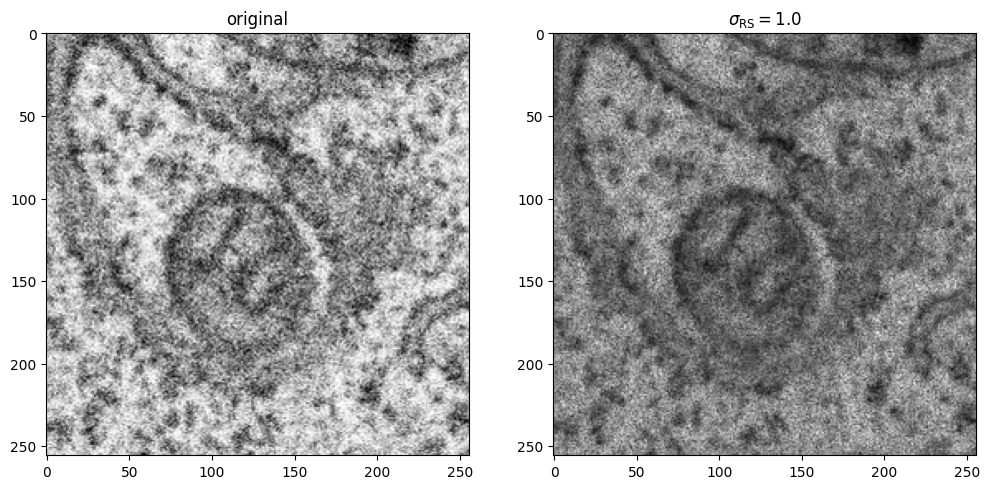

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(r"$\sigma_\text{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15], cmap="gray")

In [157]:
import skimage.io

In [158]:
skimage.io.imsave(f"denoised.tif", denoised_vol, imagej=True)

In [ ]:
%%bash
ls -l

In [ ]:
input()

In [ ]:
# Load the images
image1 = opticalflow3D.helpers.load_image(r"E:\data\3DTFM\test_set\image1.tif")
image2 = opticalflow3D.helpers.load_image(r"E:\data\3DTFM\test_set\image2.tif")

In [ ]:
# Realign the image manually to remove any drift during the acquisition of the image
image1 = opticalflow3D.helpers.crop_image(image1, z_reverse=True, z_start=2, y_start=1, x_start=1)
image2 = opticalflow3D.helpers.crop_image(image2, z_reverse=True, z_end=-2, y_end=-1, x_end=-1)

In [ ]:
output_vz, output_vy, output_vx, output_confidence = farneback.calculate_flow(image1, image2,
                                                                              start_point=(0, 300, 300),
                                                                              total_vol=(512, 512, 512),
                                                                              sub_volume=(350, 350, 350),
                                                                              overlap=(64, 64, 64),
                                                                              threadsperblock=(8, 8, 8),
                                                                             )

In [ ]:
opticalflow3D.helpers.save_displacements("vectors.npz", output_vz, output_vy, output_vx)
opticalflow3D.helpers.save_confidence("confidence.npz", output_confidence)

## Perform qualitative/quatitative assessment of vectors

In [ ]:
import numpy as np
import skimage.io
import skimage.metrics

In [ ]:
start_point=(0, 300, 300)
total_vol=(512, 512, 512)
cropped_image1 = image1[start_point[0]:start_point[0]+total_vol[0],
                        start_point[1]:start_point[1]+total_vol[1],
                        start_point[2]:start_point[2]+total_vol[2]]

cropped_image2 = image2[start_point[0]:start_point[0]+total_vol[0],
                        start_point[1]:start_point[1]+total_vol[1],
                        start_point[2]:start_point[2]+total_vol[2]]

In [ ]:
inverse_image = opticalflow3D.helpers.generate_inverse_image(cropped_image1, output_vx, output_vy, output_vz)

In [ ]:
output_image = np.moveaxis(np.stack((inverse_image, cropped_image2)), 0, 1)
skimage.io.imsave(f"comparison_image.tif", output_image, imagej=True)

In [ ]:
nrmse = skimage.metrics.normalized_root_mse(cropped_image2, inverse_image)
print(f"Normalized root mse: {nrmse}")

In [ ]:
output_image = np.moveaxis(np.stack((inverse_image, cropped_image2)), 0, 1)
skimage.io.imsave(f"comparison_image.tif", output_image, imagej=True)